In [1]:
import os
os.chdir('../')
current_directory = os.getcwd()
print("Current Directory:", current_directory)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

import warnings; 
warnings.simplefilter('ignore')

Current Directory: c:\Users\Darren Chong\Documents\School\Thesis B\Spectrogram-Based-Omics-Imagification


In [2]:
expr_file1 = r"./data/baron/GSM2230757_human1_umifm_counts.csv.gz"
expr_file2 = r"./data/baron/GSM2230758_human2_umifm_counts.csv.gz"
expr_file3 = r"./data/baron/GSM2230759_human3_umifm_counts.csv.gz"
expr_file4 = r"./data/baron/GSM2230760_human4_umifm_counts.csv.gz"
expr1 = pd.read_csv(expr_file1, sep=",")
expr2 = pd.read_csv(expr_file2, sep=",")
expr3 = pd.read_csv(expr_file3, sep=",")
expr4 = pd.read_csv(expr_file4, sep=",")
expr = pd.concat([expr1, expr2, expr3, expr4], ignore_index=True)

y = expr['assigned_cluster'].values
X = expr.iloc[:, 3:].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)
print(np.unique(y, return_counts=True))


(array(['acinar', 'activated_stellate', 'alpha', 'beta', 'delta', 'ductal',
       'endothelial', 'epsilon', 'gamma', 'macrophage', 'mast',
       'quiescent_stellate', 'schwann', 't_cell'], dtype=object), array([ 958,  284, 2326, 2525,  601, 1077,  252,   18,  255,   55,   25,
        173,   13,    7], dtype=int64))


In [3]:
def scaler_fit(X: np.ndarray) -> tuple:
    """Compute parameters needed for log normalization and scaling."""
    min0 = X.min(axis=0)
    max_val = np.log(X + np.abs(min0) + 1).max()
    return min0, max_val

def scaler_transform(X: np.ndarray, min0: np.ndarray, max_val: float) -> np.ndarray:
    """Apply log normalization and scaling to the input data."""
    X_norm = np.log(X + np.abs(min0) + 1).clip(0, None)
    return (X_norm / max_val).clip(0, 1)

def scaler_fit_transform(X: np.ndarray) -> np.ndarray:
    """Combine fitting and transforming steps."""
    min0, max_val = scaler_fit(X)
    return (scaler_transform(X, min0, max_val), min0, max_val)

(X_train_norm, min0, max_val) = scaler_fit_transform(X_train)
X_test_norm = scaler_transform(X_test, min0, max_val)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size

Training Accuracy: 0.7981035740335521
Test Accuracy: 0.795215869311552
Precision (Macro): 0.44436807136728135
Precision (Micro): 0.795215869311552
Precision (Weighted): 0.8162400101653264
Recall (Macro): 0.3203972186073951
Recall (Micro): 0.795215869311552
Recall (Weighted): 0.795215869311552
F1-score (Macro): 0.30845974989693187
F1-score (Micro): 0.795215869311552
F1-score (Weighted): 0.7481172127509534
ROC-AUC (OvO, Macro): 0.8846965727883775
ROC-AUC (OvO, Weighted): 0.8234628996328395


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       192
           1       1.00      0.60      0.75        57
           2       0.96      0.98      0.97       465
           3       0.90      0.97      0.93       505
           4       1.00      0.03      0.06       120
           5       0.42      0.90      0.57       215
           6       1.00      0.04      0.08        50
           7       0.00      0.00      0.00         4
           8      

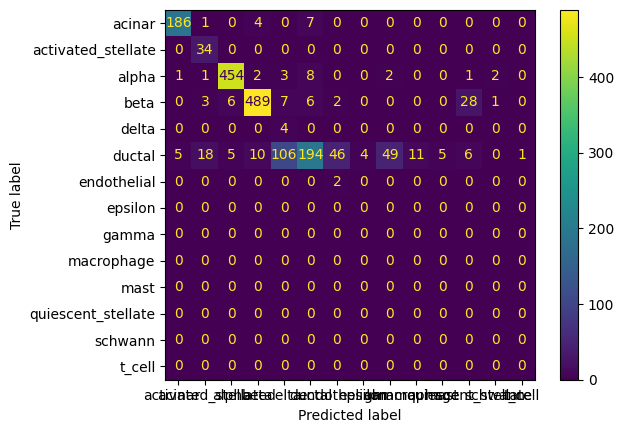

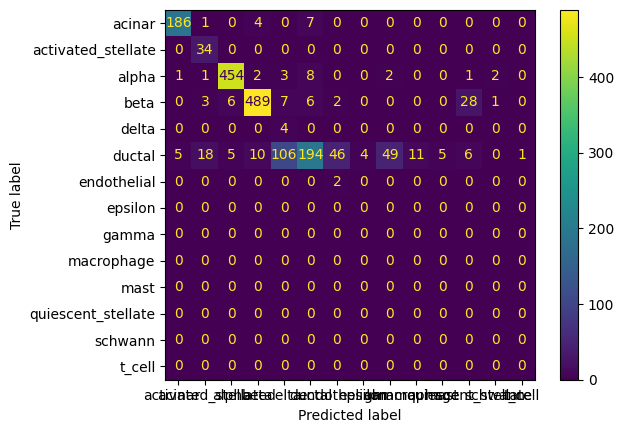

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

clf = AdaBoostClassifier(n_estimators=50, algorithm='SAMME', random_state=42)
clf.fit(X_train_norm, y_train_enc)
y_pred = clf.predict(X_test_norm)
# Calculate evaluation metrics
precision_macro = precision_score(y_test_enc, y_pred, average='macro')
precision_micro = precision_score(y_test_enc, y_pred, average='micro')
precision_weighted = precision_score(y_test_enc, y_pred, average='weighted')
recall_macro = recall_score(y_test_enc, y_pred, average='macro')
recall_micro = recall_score(y_test_enc, y_pred, average='micro')
recall_weighted = recall_score(y_test_enc, y_pred, average='weighted')
f1_macro = f1_score(y_test_enc, y_pred, average='macro')
f1_micro = f1_score(y_test_enc, y_pred, average='micro')
f1_weighted = f1_score(y_test_enc, y_pred, average='weighted')
roc_auc_macro = roc_auc_score(y_test_enc, clf.predict_proba(X_test), average='macro', multi_class='ovo')
roc_auc_weighted = roc_auc_score(y_test_enc, clf.predict_proba(X_test), average='weighted', multi_class='ovo')
# Classification report (includes precision, recall, F1-score, support)
report = classification_report(y_test_enc, y_pred)

train_accuracy = accuracy_score(y_train_enc, clf.predict(X_train_norm))

# Calculate test accuracy
test_accuracy = accuracy_score(y_test_enc, y_pred)


print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Precision (Macro):", precision_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Weighted):", recall_weighted)
print("F1-score (Macro):", f1_macro)
print("F1-score (Micro):", f1_micro)
print("F1-score (Weighted):", f1_weighted)
print("ROC-AUC (OvO, Macro):", roc_auc_macro)
print("ROC-AUC (OvO, Weighted):", roc_auc_weighted)
print("\n")
print(report)
disp = ConfusionMatrixDisplay.from_predictions(y_pred, y_test_enc, display_labels=le.classes_)
disp.plot()